In [1]:
import numpy as np 

## ニューラルネットワークの復習

In [6]:
w1 = np.random.randn(2, 4)
b1 = np.random.randn(4)
x = np.random.randn(10, 2)

h = np.dot(x, w1) + b1

h.shape

(10, 4)

In [7]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [9]:
x = np.random.randn(10, 2)
w1 = np.random.randn(2, 4)
b1 = np.random.randn(4)
w2 = np.random.randn(4, 3)
b2 = np.random.randn(3)

h = np.dot(x, w1) + b1
a = sigmoid(h)
s = np.dot(a, w2) + b2
s.shape

(10, 3)

In [22]:
# layerの実装

# シグモイド
class Sigmoid:
    def __init__(self):
        self.params = []

    def forward(self, x):
        return 1 / (1 + np.exp(-x))


# 全結合
class Affine:
    def __init__(self, W, b):
        self.params = [W, b]

    def forward(self, x):
        W, b = self.params
        out =  np.dot(x, W) + b
        return out

In [34]:
# aff -> sig -> aff

class TwolayerNet:
    def __init__(self, input_size, hidden_size, output_size):

        # レイヤーの生成
        I, H, O = input_size, hidden_size, output_size
        w1 = np.random.randn(I, H)
        b1 = np.random.randn(H)
        w2 = np.random.randn(H, O)
        b2 = np.random.randn(O)

        self.layers = [
            Affine(w1, b1),
            Sigmoid(),
            Affine(w2, b2)
        ]

        # パラメータをまとめる
        self.params = []
        for layer in self.layers:
            self.params += layer.params

    # 推論
    def predict(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
        

In [35]:
# 実際に推論してみる
x = np.random.randn(10,2)
model = TwolayerNet(2, 4, 3)
s = model.predict(x)

In [40]:
model.params

[array([[-0.45169862, -0.22800835, -0.97227584, -0.37928813],
        [-2.17279999, -0.59518809,  1.96000837, -0.2470133 ]]),
 array([-0.59460211, -0.98188608,  0.62442778, -1.16866044]),
 array([[ 1.01374973, -0.37232415, -1.15848661],
        [ 0.16891674,  0.54420896,  0.79923485],
        [-1.88120017, -0.15914182,  0.83001465],
        [-0.55969501,  0.6535826 ,  1.08176436]]),
 array([-1.48414064,  0.07911855, -0.16433585])]

In [41]:
s

array([[-1.07863063,  0.14960528, -0.34004083],
       [-3.42803349,  0.09143038,  0.92831842],
       [-1.7830109 ,  0.13630769,  0.04829085],
       [-3.35649446,  0.07588756,  0.87139536],
       [-2.56264729,  0.14775557,  0.49238655],
       [-3.28752594,  0.17730357,  0.96369396],
       [-1.00903517,  0.13910992, -0.39132568],
       [-1.18459114,  0.12566364, -0.29887757],
       [-1.65496377,  0.15545846, -0.01455686],
       [-3.39700139,  0.16760898,  1.01331101]])

In [53]:
# Repeatノード
D, N = 8, 7

# forward
x = np.ones([1, D])
y = np.repeat(x, N, axis=0)

# backward
dy = np.ones([N, D])
dx = np.sum(dy, axis=0, keepdims=True)

In [55]:
# MatMulのレイヤ
class MatMul:
    def __init__(self, W):
        self.param = [W]
        self.grad = [np.zeros_like(W)]
        self.x = None


    def forward(self, x):
        W, = self.params
        self.x = x
        out = np.dot(x, W)
        return out

    def backward(self, dout):
        W, = self.params
        dx = np.dot(dout, W.T)
        dw = np.dot(self.x.T, dout)
        self.grad[0][...] = dw # 3点リーダーで元の配列を保管していたメモリに値を格納
        return dx

In [79]:
# sigmoid layer

class Sigmoid:
    def __init__(self):
        self.params, self.grad = [], []
        self.out = None


    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1 - self.out) * self.out
        return dx

In [81]:
# Affine layer

class Affine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grad = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None


    def forward(self, x):
        W, b = self.params
        out = np.dot(x, W) + b
        self.x = x
        return out

    def backward(self, dout):
        W, b = self.params
        dx = np,dot(dout, W.T)
        dw = np.dot(self.x.T, dout)
        db = np.sum(dout, axis=0) # バッチ数分repeatされていると考えている。
        
        self.grad[0][...] = dw
        self.grad[1][...] = db

## ニューラルネットワークで問題を解く

In [5]:
from hidden_others.dataset import spiral
import matplotlib.pyplot as plt

In [3]:
x, t = spiral.load_data()
print(x.shape)
print(t.shape)

(300, 2)
(300, 3)


In [8]:
x * t[:, 0]

ValueError: operands could not be broadcast together with shapes (300,2) (300,) 

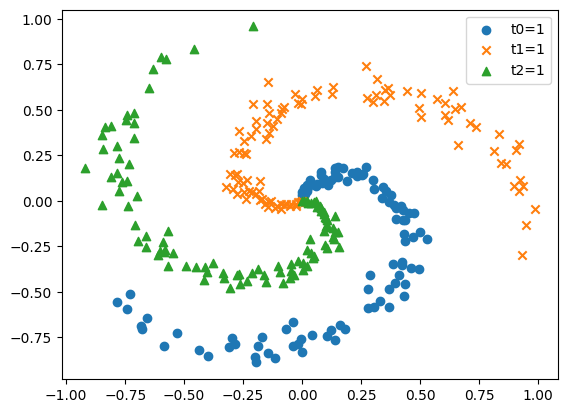

In [33]:
# 各正解ラベルのデータを抜き出す
t_0 = x[t[:, 0] == 1]
t_1 = x[t[:, 1] == 1]
t_2 = x[t[:, 2] == 1]

plt.scatter(t_0[:, 0], t_0[:, 1], marker='o', label='t0=1')
plt.scatter(t_1[:, 0], t_1[:, 1], marker='x', label='t1=1')
plt.scatter(t_2[:, 0], t_2[:, 1], marker='^', label='t2=1')
plt.legend()

In [2]:
from common.layers import Affine, Sigmoid, SigmoidWithLoss

In [3]:
import numpy as np
from common.layers import Affine, Sigmoid, SoftmaxWithLoss


class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size):
        I, H, O = input_size, hidden_size, output_size

        # 重みとバイアスの初期化
        W1 = 0.01 * np.random.randn(I, H)
        b1 = np.zeros(H)
        W2 = 0.01 * np.random.randn(H, O)
        b2 = np.zeros(O)

        # レイヤの生成
        self.layers = [
            Affine(W1, b1),
            Sigmoid(),
            Affine(W2, b2)
        ]
        self.loss_layer = SoftmaxWithLoss()

        # すべての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def forward(self, x, t):
        score = self.predict(x)
        loss = self.loss_layer.forward(score, t)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

| epoch 1 |  iter 10 / 10 | loss 1.13
| epoch 2 |  iter 10 / 10 | loss 1.13
| epoch 3 |  iter 10 / 10 | loss 1.12
| epoch 4 |  iter 10 / 10 | loss 1.12
| epoch 5 |  iter 10 / 10 | loss 1.11
| epoch 6 |  iter 10 / 10 | loss 1.14
| epoch 7 |  iter 10 / 10 | loss 1.16
| epoch 8 |  iter 10 / 10 | loss 1.11
| epoch 9 |  iter 10 / 10 | loss 1.12
| epoch 10 |  iter 10 / 10 | loss 1.13
| epoch 11 |  iter 10 / 10 | loss 1.12
| epoch 12 |  iter 10 / 10 | loss 1.11
| epoch 13 |  iter 10 / 10 | loss 1.09
| epoch 14 |  iter 10 / 10 | loss 1.08
| epoch 15 |  iter 10 / 10 | loss 1.04
| epoch 16 |  iter 10 / 10 | loss 1.03
| epoch 17 |  iter 10 / 10 | loss 0.96
| epoch 18 |  iter 10 / 10 | loss 0.92
| epoch 19 |  iter 10 / 10 | loss 0.92
| epoch 20 |  iter 10 / 10 | loss 0.87
| epoch 21 |  iter 10 / 10 | loss 0.85
| epoch 22 |  iter 10 / 10 | loss 0.82
| epoch 23 |  iter 10 / 10 | loss 0.79
| epoch 24 |  iter 10 / 10 | loss 0.78
| epoch 25 |  iter 10 / 10 | loss 0.82
| epoch 26 |  iter 10 / 10 | loss 

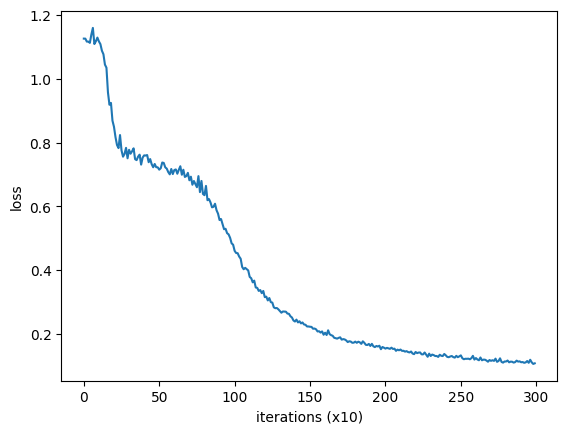

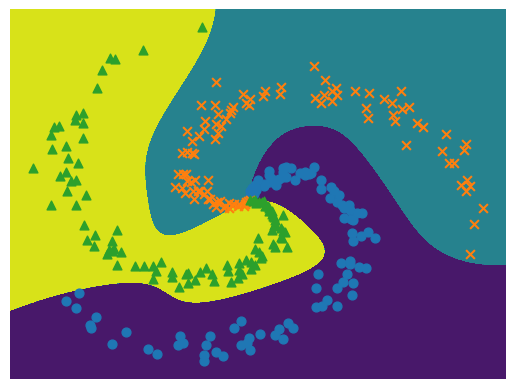

In [6]:
from common.optimizer import SGD

# ハイパーパラメータの設定
max_epoch = 300
batch_size = 30
hidden_size = 10
learning_rate = 1.0

x, t = spiral.load_data()
model = TwoLayerNet(input_size=2, hidden_size=hidden_size, output_size=3)
optimizer = SGD(lr=learning_rate)

# 学習で使用する変数
data_size = len(x)
max_iters = data_size // batch_size
total_loss = 0
loss_count = 0
loss_list = []

for epoch in range(max_epoch):
    # データのシャッフル
    idx = np.random.permutation(data_size)
    x = x[idx]
    t = t[idx]

    for iters in range(max_iters):
        batch_x = x[iters*batch_size:(iters+1)*batch_size]
        batch_t = t[iters*batch_size:(iters+1)*batch_size]

        # 勾配を求め、パラメータを更新
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)

        total_loss += loss
        loss_count += 1

        # 定期的に学習経過を出力
        if (iters+1) % 10 == 0:
            avg_loss = total_loss / loss_count
            print('| epoch %d |  iter %d / %d | loss %.2f'
                  % (epoch + 1, iters + 1, max_iters, avg_loss))
            loss_list.append(avg_loss)
            total_loss, loss_count = 0, 0


# 学習結果のプロット
plt.plot(np.arange(len(loss_list)), loss_list, label='train')
plt.xlabel('iterations (x10)')
plt.ylabel('loss')
plt.show()

# 境界領域のプロット
h = 0.001
x_min, x_max = x[:, 0].min() - .1, x[:, 0].max() + .1
y_min, y_max = x[:, 1].min() - .1, x[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
X = np.c_[xx.ravel(), yy.ravel()]
score = model.predict(X)
predict_cls = np.argmax(score, axis=1)
Z = predict_cls.reshape(xx.shape)
plt.contourf(xx, yy, Z)
plt.axis('off')

# データ点のプロット
x, t = spiral.load_data()
N = 100
CLS_NUM = 3
markers = ['o', 'x', '^']
for i in range(CLS_NUM):
    plt.scatter(x[i*N:(i+1)*N, 0], x[i*N:(i+1)*N, 1], s=40, marker=markers[i])
plt.show()

| epoch 1 |  iter 1 / 10 | time 0[s] | loss 1.10
| epoch 2 |  iter 1 / 10 | time 0[s] | loss 1.12
| epoch 3 |  iter 1 / 10 | time 0[s] | loss 1.13
| epoch 4 |  iter 1 / 10 | time 0[s] | loss 1.12
| epoch 5 |  iter 1 / 10 | time 0[s] | loss 1.12
| epoch 6 |  iter 1 / 10 | time 0[s] | loss 1.10
| epoch 7 |  iter 1 / 10 | time 0[s] | loss 1.14
| epoch 8 |  iter 1 / 10 | time 0[s] | loss 1.16
| epoch 9 |  iter 1 / 10 | time 0[s] | loss 1.11
| epoch 10 |  iter 1 / 10 | time 0[s] | loss 1.12
| epoch 11 |  iter 1 / 10 | time 0[s] | loss 1.12
| epoch 12 |  iter 1 / 10 | time 0[s] | loss 1.12
| epoch 13 |  iter 1 / 10 | time 0[s] | loss 1.10
| epoch 14 |  iter 1 / 10 | time 0[s] | loss 1.09
| epoch 15 |  iter 1 / 10 | time 0[s] | loss 1.08
| epoch 16 |  iter 1 / 10 | time 0[s] | loss 1.04
| epoch 17 |  iter 1 / 10 | time 0[s] | loss 1.03
| epoch 18 |  iter 1 / 10 | time 0[s] | loss 0.94
| epoch 19 |  iter 1 / 10 | time 0[s] | loss 0.92
| epoch 20 |  iter 1 / 10 | time 0[s] | loss 0.92
| epoch 2

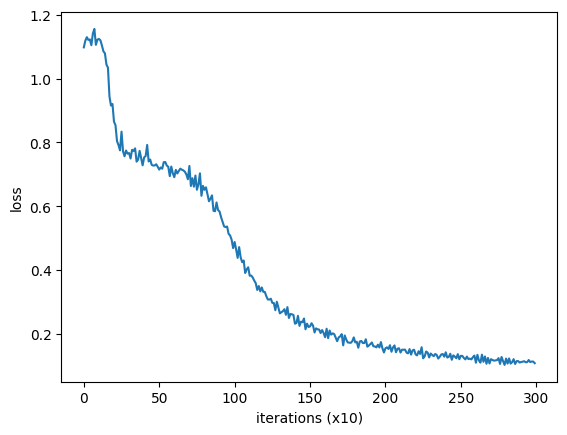

In [14]:
from common.optimizer import SGD
from common.trainer import Trainer

max_epoch = 300
batch_size = 30
hidden_size = 10
learning_rate = 1.0

x, t = spiral.load_data()
model = TwoLayerNet(input_size=2, hidden_size=hidden_size, output_size=3)
optimizer = SGD(lr=learning_rate)

trainer = Trainer(model, optimizer)
trainer.fit(x, t, batch_size=batch_size, max_epoch=max_epoch, eval_interval=10)
trainer.plot()